In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from kmodes.kprototypes import KPrototypes
from scipy.optimize import curve_fit
import seaborn as sns



# 1- Dades de consum clusteritzades

    - El fitxer de dades conté 20 columnes i 2.444.832 files (interaccions o unitats de consum)
    - L'ultima columna "Segment" correspon a l'etiqueta del clústes. És a dir, a quin clúster pertany cada consum (C1,...,C5).
    - Les 19 columnes restants caracteritzen les unitats de consum:
        - min_data:  hora inici reproducció
        - durada_consum: durada del consum
        - durada: durada del videoclip consumit
        - usuari_id: identificador de l'usuari logat
        - player_id: identificador de la reproducció
        - producte_id: plataforma des de la qual s'ha consumit (PortalCCMA, appTV3...)
        - contingut_id: identificador del contingut
        - canal_nom: nom del canal
        - programa_nom: nom del programa
        - programa_capitol: capitol (1,2,3...)
        - tematica: tematica del programa (mal informada)
        - dispositiu_accepta_cookies: si accepta o no cookies
        - dispositiu_model: model del dispositiu
        - dispositiu_vendor: marca del dispositiu
        - dispositiu_browser_nom: navegador utilitzat
        - dispositiu_tipus: tipus de dispositiu
        - year: any de consum  
        - day: dia de la setmana del consum
        - month: mes de l'any del consum
        

In [8]:
df = pd.read_csv('dades_consum_cluster.csv')   # Llegim el fitxer de dades
df

C:\Users\josep\anaconda3\envs\ox\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,min_data,durada_consum,durada,usuari_id,player_id,producte_id,contingut_id,canal_nom,programa_nom,programa_capitol,tematica,dispositiu_accepta_cookies,dispositiu_model,dispositiu_vendor,dispositiu_browser_nom,dispositiu_tipus,year,day,month,Segment
0,72083.0,224.0,3425.0,cd59b5d0eadd11e78b917b6a96b37d13,532431546297264625,PortalCCMA,5808597,TV3,Howards End,4.0,FICCIÓ,True,ANDROID,NaN,CHROME,TABLET,2019,Tuesday,January,C3
1,72170.0,936.0,2760.0,ef3a5e305a3011e8b2856b1b1792d2d5,151871546297352716,PortalCCMA,5809807,TV3,Telenotícies,5214.0,ACTUALITAT,True,ANDROID,NaN,CHROME,MOBILE,2019,Tuesday,January,C3
2,72283.0,6821.0,5825.0,971bc1a0d61711e7997557f16f7e845d,94429,appMobil_tv3,5808127,TV3,Pel·lícules,1.0,FICCIÓ,True,ANDROID,HUAWEI,ANDROID BROWSER,MOBILE,2019,Tuesday,January,C4
3,72288.0,0.0,49.0,58169d60b60c11e885daa1c496d066bd,16755,appMobil_tv3,5809111,TV3,TV3,NaN,PROMOCIÓ CADENA,True,ANDROID,NaN,CHROME,MOBILE,2019,Tuesday,January,C3
4,72329.0,0.0,49.0,7c5460400d5011e9b7c3ab71693993b0,81949,appMobil_tv3,5809111,TV3,TV3,NaN,PROMOCIÓ CADENA,False,ANDROID,NaN,CHROME,MOBILE,2019,Tuesday,January,C3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2444828,70036.0,60.0,95.0,b8cb5320da4a11eb971ae3fd86aee49d,829171632259572094,PortalCCMA,6120002,TV3,Telenotícies comarques,5795.0,ACTUALITAT,True,ANDROID,NaN,CHROME,MOBILE,2021,Tuesday,September,C3
2444829,70038.0,0.0,2757.0,88d72a800bda11eabdcfd32cdc687e54,835391632259631354,appTV_tv3,6118323,TV3,Crims,22.0,DIVULGACIÓ,True,UE43RU7405UXXC,SAMSUNG,SAFARI,TV,2021,Tuesday,September,C3
2444830,70040.0,27.0,29.0,30b501201b1311eca51e3d25c93f171e,541771632259650113,PortalCCMA,6120006,TV3,Notícies 3/24,6569.0,MÓN,False,WINDOWS,NaN,CHROME,PC,2021,Tuesday,September,C3
2444831,70063.0,120.0,2757.0,db8526d01b2111ecbee3a178ccf276eb,892101632259411606,appMobil_tv3,6118323,TV3,Crims,22.0,DIVULGACIÓ,False,ANDROID,NaN,CHROME,MOBILE,2021,Tuesday,September,C3


# 2- Hora d'inici de la reproducció

Representem la pdf normalitzada (densitat sota de la corva = 1) de l'hora d'inici del consum.

    - Utilitzem caixes de 5 minuts (300s). 
    - Hem realitat un shift per realitzar els càlculs i el clustering de 4h, per posar l'origen on el consum és mínim. 
      Desfem el shift per representar la pdf.
    

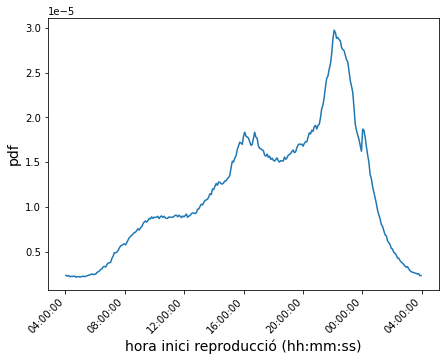

In [11]:
fig, ax1 = plt.subplots(figsize=(7,5)) 

bins=int((max(df['min_data'])-min(df['min_data']))/300.)  # Number of bins (boxes). Every 300s (5min).
hora_inici=df['min_data'].tolist()  
numpy_matrix = np.array(hora_inici)  # List of hora_inici to array
counts_agregat,bin_edges = np.histogram(numpy_matrix,bins,density=True)   # Obtain frequences and bins
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   # Center of each bin


# we need to do this step to undo the 4 hour time shift for visualisation (adding 4h, i.e. 14400 seconds)
bin_centres_shift_agregat=[]   
for i in range(len(bin_centres)):
    bin_centres_shift_agregat.append(bin_centres[i]+14400)
    
    
ax1.plot(bin_centres_shift_agregat, counts_agregat, '-', label='data')    # plot pdf 
ax1.set_xlabel('hora inici reproducció (hh:mm:ss)',fontsize=14)  # labels
ax1.set_ylabel('pdf',fontsize=14)
#ax1.set_yscale('log',basey=10)   # logscale
#ax1.set_xscale('log',basex=10)


# Change the x-axis. From total seconds to the hour of the day
major_ticks = np.arange(14400, 100801, 14400)
#major_ticks = np.arange(0, 86401, 14400)

ax1.set_xticks(major_ticks)

locs, labels=plt.xticks()
new_xticks=[]
for i in locs:
    ty_res = time.gmtime(i)
    res = time.strftime("%H:%M:%S",ty_res)
    new_xticks.append(res)
    
plt.xticks(locs,new_xticks, rotation=45, horizontalalignment='right')


plt.show()

# 3- Durada del consum

    - Valor mig i desviació estàndard de les duracions dels consums
    - Pdf en escala semi-log i amb inset log-log
    - Pdf escala normal
    - Ddf (decumulative) en escala log-log
    - Utilitzem bins d'un minut (60s).

In [13]:
durada_consum=df['durada_consum'].tolist()   # consumption duration to list

mean = sum(durada_consum)/len(durada_consum)  # mean value and standard deviation
variance = sum([((x - mean) ** 2) for x in durada_consum]) / len(durada_consum)
stddev = variance ** 0.5     

ty_res = time.gmtime(mean)  # from total seconds to HH:MM:SS format
res = time.strftime("%H:%M:%S",ty_res)
ty_res2 = time.gmtime(stddev)
res2 = time.strftime("%H:%M:%S",ty_res2)

print('Valor mig de la durada del consum: <d>=', mean, 's', '', '=>', '', res)
print('Desviació estàndard: sigma=', stddev, 's', '', '=>', '', res2)

Valor mig de la durada del consum: <d>= 1288.9360753883802 s  =>  00:21:28
Desviació estàndard: sigma= 2980.405043606321 s  =>  00:49:40


<ipython-input-17-b28c2421397d>:18: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-17-b28c2421397d>:23: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axins2.set_yscale('log',basey=10)
<ipython-input-17-b28c2421397d>:24: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axins2.set_xscale('log',basex=10)
<ipython-input-17-b28c2421397d>:25: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axins2.set_xlim(-1000,30000)


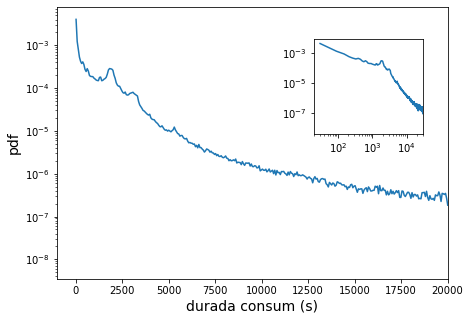

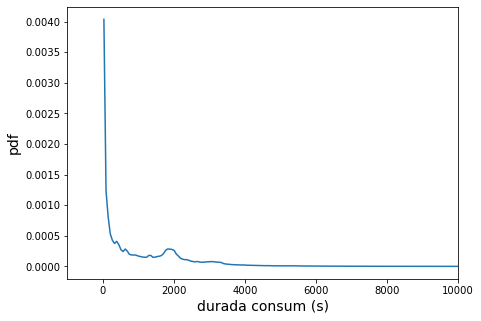

<ipython-input-17-b28c2421397d>:75: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-17-b28c2421397d>:76: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


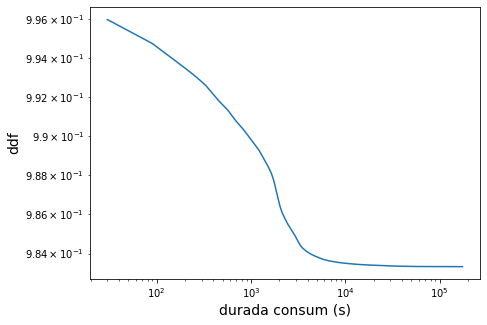

In [17]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#### SEMI-LOG WITH INSET LOG-LOG

fig, ax1 = plt.subplots(figsize=(7,5)) 

bins=int((max(df['durada_consum'])-min(df['durada_consum']))/60.)   # bins of 1 minute.
durada_consum=df['durada_consum'].tolist()
numpy_matrix = np.array(durada_consum)  #list to array
counts_consum,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
bin_centres_consum = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center



ax1.plot(bin_centres_consum, counts_consum, '-', label='data')    #plot pdf
ax1.set_xlabel('durada consum (s)',fontsize=14)
ax1.set_ylabel('pdf',fontsize=14)
ax1.set_yscale('log',basey=10)
#ax1.set_xscale('log',basex=10)
ax1.set_xlim(-1000,20000)
axins2 = inset_axes(ax1, width="80%", height="100%", loc=1,bbox_to_anchor=(0.60,1-0.45,.35,.35), bbox_transform=ax1.transAxes)
axins2.plot(bin_centres_consum, counts_consum, '-')
axins2.set_yscale('log',basey=10)
axins2.set_xscale('log',basex=10)
axins2.set_xlim(-1000,30000)
plt.show()



#########################################################################



#### LINEAR SCALE

fig, ax1 = plt.subplots(figsize=(7,5)) 

bins=int((max(df['durada_consum'])-min(df['durada_consum']))/60.)
durada_consum=df['durada_consum'].tolist()
numpy_matrix = np.array(durada_consum)  #list to array
counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center

pdf=counts/sum(counts)

ax1.plot(bin_centres, counts, '-', label='data')    #plot pdf
ax1.set_xlabel('durada consum (s)',fontsize=14)
ax1.set_ylabel('pdf',fontsize=14)
#ax1.set_yscale('log',basey=10)
#ax1.set_xscale('log',basex=10)
ax1.set_xlim(-1000,10000)
plt.show()




#########################################################################

#### DECUMULATIVE LOG-LOG

fig, ax1 = plt.subplots(figsize=(7,5)) 

bins=int((max(df['durada_consum'])-min(df['durada_consum']))/60.)
durada_consum=df['durada_consum'].tolist()
numpy_matrix = np.array(durada_consum)  #list to array
counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center

cdf = np.cumsum(counts)
dcdf=1-cdf

ax1.plot(bin_centres, dcdf, '-', label='data')    #plot pdf
ax1.set_xlabel('durada consum (s)',fontsize=14)
ax1.set_ylabel('ddf',fontsize=14)
ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)
#ax1.set_xlim(-100,4000)
plt.show()

# 4- Durada del videoclip

    - Valor mig i desviació estàndard de les duracions dels consums
    - Pdf en escala lineal i amb inset log-log
    - Ddf (decumulative) en escala log-log
    - Utilitzem bins d'un minut (60s).

In [20]:
durada_videoclip=df['durada'].tolist()

mean = sum(durada_videoclip)/len(durada_videoclip)  # mean value and std
variance = sum([((x - mean) ** 2) for x in durada_videoclip]) / len(durada_videoclip)
stddev = variance ** 0.5     

ty_res = time.gmtime(mean)  # toformat HH:MM:SS
res = time.strftime("%H:%M:%S",ty_res)
ty_res2 = time.gmtime(stddev)
res2 = time.strftime("%H:%M:%S",ty_res2)

print('Valor mig de la durada: <d>=', mean, 's','', '=>', '', res)
print('Desviació estàndard: sigma=', stddev, 's','', '=>', '', res2)

Valor mig de la durada: <d>= 2422.884191680986 s  =>  00:40:22
Desviació estàndard: sigma= 2480.320525335294 s  =>  00:41:20


<ipython-input-23-bb14f950a151>:21: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axins2.set_yscale('log',basey=10)
<ipython-input-23-bb14f950a151>:22: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  axins2.set_xscale('log',basex=10)
<ipython-input-23-bb14f950a151>:23: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axins2.set_xlim(-500,15000)


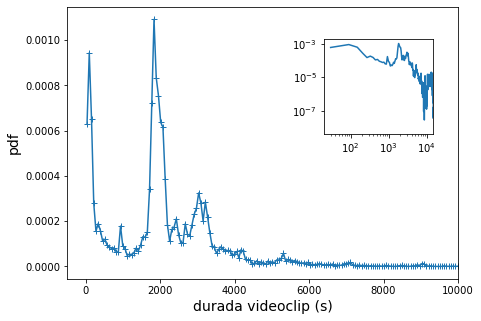

<ipython-input-23-bb14f950a151>:48: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-23-bb14f950a151>:49: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


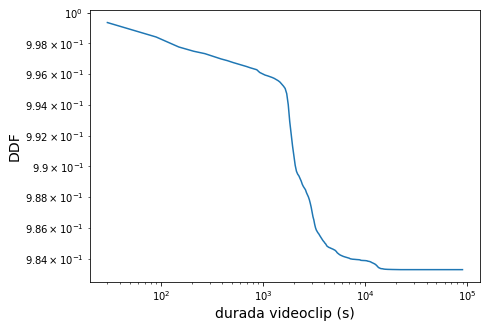

In [23]:
###LINEAR SCALE WITH INSET LOG-LOG

fig, ax1 = plt.subplots(figsize=(7,5)) 

durada=df['durada'].tolist()
bins=int((max(df['durada'])-min(df['durada']))/60.)
numpy_matrix = np.array(durada)  #list to array
counts_durada,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
bin_centres_durada = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center


ax1.plot(bin_centres_durada, counts_durada, '-+', label='data')    #plot pdf
ax1.set_xlabel('durada videoclip (s)',fontsize=14)
ax1.set_ylabel('pdf',fontsize=14)
#ax1.set_yscale('log',basey=10)
#ax1.set_xscale('log',basex=10)
ax1.set_xlim(-500,10000)

axins2 = inset_axes(ax1, width="80%", height="100%", loc=1,bbox_to_anchor=(0.60,1-0.45,.35,.35), bbox_transform=ax1.transAxes)
axins2.plot(bin_centres_durada, counts_durada, '-')
axins2.set_yscale('log',basey=10)
axins2.set_xscale('log',basex=10)
axins2.set_xlim(-500,15000)


plt.show()




##########################################################

### DECUMULATIVE LOG-LOG

fig, ax1 = plt.subplots(figsize=(7,5)) 

durada=df['durada'].tolist()
numpy_matrix = np.array(durada)  #list to array
counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center

cdf = np.cumsum(counts)
dcdf=1-cdf

ax1.plot(bin_centres, dcdf, '-', label='data')    #plot pdf
ax1.set_xlabel('durada videoclip (s)',fontsize=14)
ax1.set_ylabel('DDF',fontsize=14)
ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)
#ax1.set_ylim(0.000000001,10)
plt.show()


# 5- RESULTATS DEL CLUSTERING

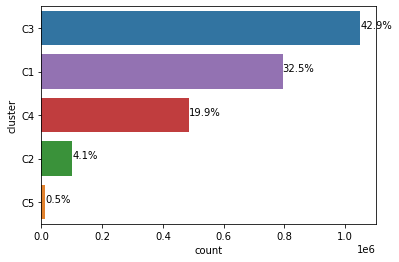

C3    1050006
C1     793958
C4     486972
C2     101415
C5      12482
Name: Segment, dtype: int64

In [25]:
colors=['tab:blue','tab:purple','tab:red','tab:green','tab:orange' ]
ax = sns.countplot(y=df['Segment'], data=df['Segment'],order = df['Segment'].value_counts().index, palette=colors)
plt.xlabel('count')
plt.ylabel('cluster')


total = sum(df['Segment'].value_counts())
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width()/total)
    value=p.get_width()
    x = p.get_x() + p.get_width() + 0.1
    y = p.get_y() + p.get_height()/2
    ax.annotate(percentage, (x, y))

plt.show()

df['Segment'].value_counts()

## 5.1 - Hora d'inici de la reproducció

C1

count    793958.000000
mean      28926.765013
std       11851.370358
min           0.000000
25%       20128.000000
50%       29982.000000
75%       38903.000000
max       57309.000000
Name: min_data, dtype: float64
C2

count    101415.000000
mean      46185.587941
std       20536.921999
min           2.000000
25%       30345.000000
50%       46639.000000
75%       63436.000000
max       86397.000000
Name: min_data, dtype: float64
C3

count    1.050006e+06
mean     6.265324e+04
std      9.597374e+03
min      3.402800e+04
25%      5.539600e+04
50%      6.375000e+04
75%      6.923700e+04
max      8.639900e+04
Name: min_data, dtype: float64
C4

count    486972.00000
mean      58802.02332
std       11978.52939
min       23221.00000
25%       49344.00000
50%       60078.00000
75%       67885.00000
max       86399.00000
Name: min_data, dtype: float64
C5

count    12482.000000
mean     45668.139160
std      24250.288044
min          7.000000
25%      24715.250000
50%      41582.000000
75% 

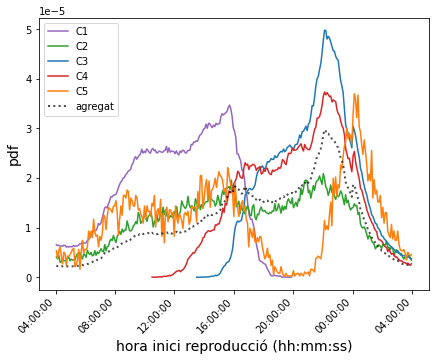

In [27]:
fig, ax1 = plt.subplots(figsize=(7,5)) 

count=0
list_labels=['C1','C2','C3','C4','C5']  
colors=['tab:purple','tab:green','tab:blue','tab:red','tab:orange' ]

for i,j in df.groupby('Segment'):
    print(i)
    print('')
    print(j.min_data.describe())
    
    #fig, ax1 = plt.subplots(figsize=(7,5)) 

    bins=int((max(j['min_data'])-min(j['min_data']))/300.) #bins of 5 minutes.
    hora_inici=j['min_data'].tolist()
    numpy_matrix = np.array(hora_inici)  #list to array
    counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center
     
    bin_centres_shift=[]    # undo 4h shift.
    for p in range(len(bin_centres)):
        bin_centres_shift.append(bin_centres[p]+14400)

    pdf=counts/sum(counts)

    ax1.plot(bin_centres_shift, counts, '-', label=list_labels[count], color=colors[count])    #plot pdf
    
    count=count+1
    
ax1.set_xlabel('hora inici reproducció (hh:mm:ss)',fontsize=14)
ax1.set_ylabel('pdf',fontsize=14)

major_ticks = np.arange(14400, 100801, 14400)
ax1.set_xticks(major_ticks)

locs, labels=plt.xticks()
new_xticks=[]
for i in locs:
    ty_res = time.gmtime(i)
    res = time.strftime("%H:%M:%S",ty_res)
    new_xticks.append(res)


ax1.plot(bin_centres_shift_agregat, counts_agregat, ':', label='agregat', color='black', linewidth=2,alpha=0.7)

plt.xticks(locs,new_xticks, rotation=45, horizontalalignment='right')

ax1.legend()

plt.show()



## 5.2- Durada del consum

C1

count    793958.000000
mean       1031.003368
std        1555.277228
min           0.000000
25%          57.000000
50%         386.000000
75%        1650.000000
max       17347.000000
Name: durada_consum, dtype: float64
C2

count    101415.000000
mean       2232.275403
std        3122.583863
min           0.000000
25%         149.000000
50%         881.000000
75%        3029.000000
max       20230.000000
Name: durada_consum, dtype: float64
C3

count    1.050006e+06
mean     1.139956e+03
std      1.427110e+03
min      0.000000e+00
25%      9.300000e+01
50%      6.050000e+02
75%      1.865000e+03
max      1.732600e+04
Name: durada_consum, dtype: float64
C4

count    486972.000000
mean       1028.444621
std        1417.434051
min           0.000000
25%          55.000000
50%         440.000000
75%        1759.000000
max       17390.000000
Name: durada_consum, dtype: float64
C5

count     12482.000000
mean      32726.326791
std       15899.938239
min       16576.000000
25%       21639.

<ipython-input-31-5a802956a21a>:33: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)


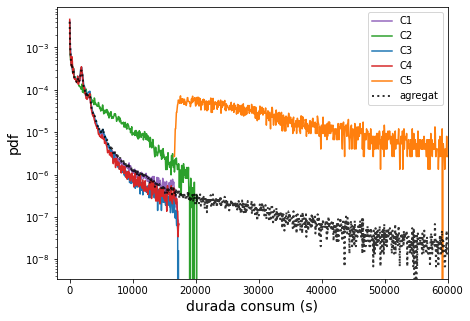

<ipython-input-31-5a802956a21a>:77: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-31-5a802956a21a>:78: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)
<ipython-input-31-5a802956a21a>:79: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_xlim(-2000,80000)


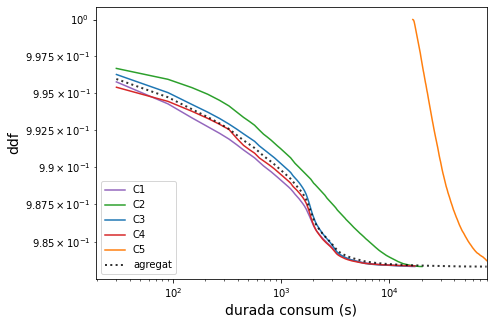

In [31]:
count=0
list_labels=['C1','C2','C3','C4','C5']  
colors=['tab:purple','tab:green','tab:blue','tab:red','tab:orange' ]
    
fig, ax1 = plt.subplots(figsize=(7,5)) 

for i,j in df.groupby('Segment'):
    print(i)
    print('')
    print(j.durada_consum.describe())
        
    #fig, ax1 = plt.subplots(figsize=(7,5)) 

    bins=int((max(j['durada_consum'])-min(j['durada_consum']))/60.) #bins of 1 minute.
    hora_inici=j['durada_consum'].tolist()
    numpy_matrix = np.array(hora_inici)  #list to array
    counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center

    ax1.plot(bin_centres, counts, '-', label=list_labels[count], color=colors[count])
    
    count=count+1

ax1.set_xlabel('durada consum (s)',fontsize=14)
ax1.set_ylabel('pdf',fontsize=14)


ax1.plot(bin_centres_consum, counts_consum, ':', label='agregat', color='black', linewidth=2,alpha=0.8)


ax1.legend()

ax1.set_yscale('log',basey=10)
#ax1.set_xscale('log',basex=10)
ax1.set_xlim(-2000,60000)
plt.show()



count=0
#list_labels=['Second','First','Fifth','Third','Fourth']



############################################################

### DECUMULATIVE LOG-LOG

fig, ax1 = plt.subplots(figsize=(7,5)) 

for i,j in df.groupby('Segment'):
 
    #fig, ax1 = plt.subplots(figsize=(7,5)) 

    bins=int((max(j['durada_consum'])-min(j['durada_consum']))/60.) #bins of 1 minute.
    hora_inici=j['durada_consum'].tolist()
    numpy_matrix = np.array(hora_inici)  #list to array
    counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center

    cdf = np.cumsum(counts)
    dcdf=1-cdf

    ax1.plot(bin_centres, dcdf, '-', label=list_labels[count], color=colors[count])
    
    count=count+1
    
ax1.set_xlabel('durada consum (s)',fontsize=14)
ax1.set_ylabel('ddf',fontsize=14)

cdf_durada_consum=np.cumsum(counts_consum)
dcdf_durada_consum=1-cdf_durada_consum
ax1.plot(bin_centres_consum, dcdf_durada_consum, ':', label='agregat', color='black', linewidth=2,alpha=0.8)


ax1.legend()
ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)
ax1.set_xlim(-2000,80000)
plt.show()

## 5.3- Durada del videoclip

C1

count    793958.000000
mean       1834.751036
std        1399.073206
min           0.000000
25%         447.000000
50%        1858.000000
75%        2695.000000
max        8255.000000
Name: durada, dtype: float64
C2

count    101415.000000
mean      12167.927841
std        2334.966699
min        5578.000000
25%       11079.000000
50%       12571.000000
75%       13423.000000
max       89950.000000
Name: durada, dtype: float64
C3

count    1.050006e+06
mean     2.035705e+03
std      1.344042e+03
min      3.000000e+00
25%      1.285000e+03
50%      1.941000e+03
75%      2.847000e+03
max      8.255000e+03
Name: durada, dtype: float64
C4

count    486972.000000
mean       2148.929345
std        1258.457033
min           3.000000
25%        1743.000000
50%        1976.000000
75%        2877.000000
max        8703.000000
Name: durada, dtype: float64
C5

count    12482.000000
mean      3913.651578
std       3328.633005
min          6.000000
25%       1949.000000
50%       2847.000000
75% 

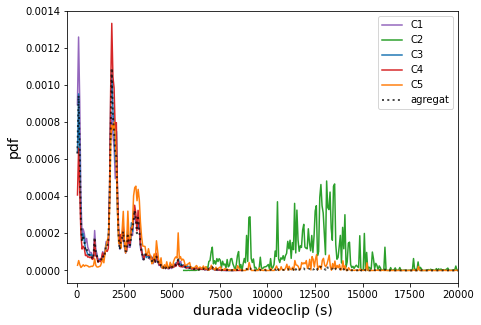

<ipython-input-34-9ebf6260485c>:66: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log',basey=10)
<ipython-input-34-9ebf6260485c>:67: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_xscale('log',basex=10)


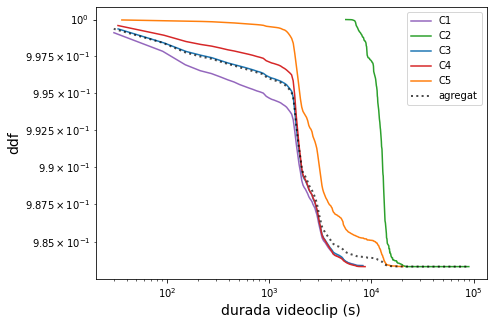

In [34]:
fig, ax1 = plt.subplots(figsize=(7,5)) 

count=0
list_labels=['C1','C2','C3','C4','C5']  
colors=['tab:purple','tab:green','tab:blue','tab:red','tab:orange' ]

for i,j in df.groupby('Segment'):
    print(i)
    print('')
    print(j.durada.describe())
        
    #fig, ax1 = plt.subplots(figsize=(7,5)) 
    
    bins=int((max(j['durada'])-min(j['durada']))/60.)  #1 minute bins.
    hora_inici=j['durada'].tolist()
    numpy_matrix = np.array(hora_inici)  #list to array
    counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center

    ax1.plot(bin_centres, counts, '-', label=list_labels[count], color=colors[count])
    
    count=count+1

ax1.set_xlabel('durada videoclip (s)',fontsize=14)
ax1.set_ylabel('pdf',fontsize=14)
ax1.set_xlim(-500,20000)
#ax1.set_yscale('log',basey=10)
#ax1.set_xscale('log',basex=10)

ax1.plot(bin_centres_durada, counts_durada, ':', label='agregat', color='black', linewidth=2, alpha=0.7)

ax1.legend()

plt.show()


#############################################################

### DECUMULATIVE LOG-LOG

fig, ax1 = plt.subplots(figsize=(7,5)) 

count=0
#list_labels=['Second','First','Fifth','Third','Fourth']

for i,j in df.groupby('Segment'):

    #fig, ax1 = plt.subplots(figsize=(7,5)) 
    
    bins=int((max(j['durada'])-min(j['durada']))/60.) #1 minute bins.
    hora_inici=j['durada'].tolist()
    numpy_matrix = np.array(hora_inici)  #list to array
    counts,bin_edges = np.histogram(numpy_matrix,bins,density=True)   #frequences and bins
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.   #bins center

    cdf = np.cumsum(counts)
    dcdf=1-cdf

    ax1.plot(bin_centres, dcdf, '-', label=list_labels[count], color=colors[count])
    
    count=count+1
    
ax1.set_xlabel('durada videoclip (s)',fontsize=14)
ax1.set_ylabel('ddf',fontsize=14)
#ax1.set_xlim(-500,40000)
ax1.set_yscale('log',basey=10)
ax1.set_xscale('log',basex=10)

cdf_durada=np.cumsum(counts_durada)
dcdf_durada=1-cdf_durada
ax1.plot(bin_centres_durada, dcdf_durada, ':', label='agregat', color='black', linewidth=2, alpha=0.7)

ax1.legend()
plt.show()